In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt
sns.set_style('ticks')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

## Detecting session with valid swim

In [3]:
swim_xls_file = pd.read_csv('analysis_sections_based_on_swim_pattern.csv', index_col=0)
swim_xls_file['folder'] = swim_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [4]:
row = swim_xls_file.iloc[-1]
folder = row['folder']
fish = row['fish']
task_type = row['task']
_ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

swim_dir = dir_folder/f'{folder}/{fish}/swim/'
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')

### Swim behavioral variables
* number of burst (peaks)
* inter-burst-interval
* max power of peaks
* average power of peaks
* first peak time

In [5]:
from scipy.signal import find_peaks
num_burst = np.zeros(r_swim.shape[0])
int_burst = np.zeros(r_swim.shape[0])
max_burst = np.zeros(r_swim.shape[0])
ave_burst = np.zeros(r_swim.shape[0])
fir_burst = np.zeros(r_swim.shape[0])

for n_burst in range(r_swim.shape[0]):
    rswim = r_swim[n_burst, 50:200]
    lswim = l_swim[n_burst, 50:200]
    swim_ = np.sqrt(rswim**2+lswim**2)
    peaks_ = find_peaks(swim_, prominence=0.5)[0] 
#     peaks_rl = rswim[peaks]>lswim[peaks]
#     peaks_r = peaks[peaks_rl]
#     peaks_l = peaks[~peaks_rl]
#     if rswim.max()>lswim.max():
#         peaks_ = peaks_r
#         swim_ = rswim
#     else:
#         peaks_ = peaks_l
#         swim_ = lswim   
    if len(peaks_) >1:
        num_burst[n_burst] = len(peaks_)/2
        int_burst[n_burst] = np.nanmean(np.diff(peaks_))
        max_burst[n_burst] = swim_.max()
        ave_burst[n_burst] = swim_[peaks_].mean()
        fir_burst[n_burst] = peaks_[0]
    
burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
burst_list = np.asarray(burst_list)

### Using PCA or LDA

In [6]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

is_pca = False
is_lda = not is_pca

if is_pca:
    pca = PCA()
    pca.fit(burst_list.T)
    burst_pca = pca.transform(burst_list.T)
    plt.scatter(burst_pca[:, 0], burst_pca[:, 1], c=task_period)
    plt.colorbar()
    plt.show()

if is_lda:
    lda_ = LDA(n_components=4)
    lda_.fit((burst_list.T)[task_period<3], task_period[task_period<3])
    burst_pca = burst_list.T.dot(lda_.coef_.T)
    burst_pca = burst_pca - np.mean(burst_pca)

In [7]:
if 'Optovin' in task_type:
    pain_stim_t = np.where(frame_stimParams[5]==1)[0]
    # for each swim we find the time to the last pain stimulation
    swim_pain_t = np.empty(len(swim_starts))
    swim_pain_t[:] = np.inf
    for n_, n_swim_start in enumerate(swim_starts):
        if (pain_stim_t<n_swim_start).sum()>0:
            # swim_pain_t[n_] = n_swim_start - pain_stim_t[pain_stim_t<n_swim_start][-1] 
            swim_pain_t[n_] = np.abs(n_swim_start - pain_stim_t).min()
    if burst_pca.shape[-1]>1:
        plt.scatter(burst_pca[task_period==1, 0], burst_pca[task_period==1, 1], c=swim_pain_t[task_period==1]/300)
        plt.colorbar()
        plt.show()

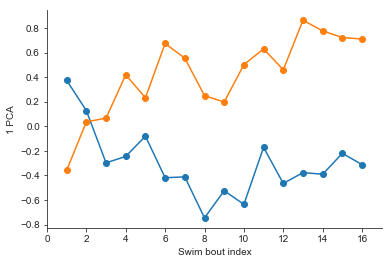

In [8]:
n_task = task_period.max().astype('int')

swim_task_index_ = (swim_task_index-1)%n_task+1
swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
swim_bout_index_task[0] = 1
for n_bout in range(len(swim_task_index_)-1):
    if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
        swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
    else:
        swim_bout_index_task[n_bout] = 1

swim_bout_index_task = swim_bout_index_task
swim_task_index_ = swim_task_index_

n_comp = 1

fig, ax = plt.subplots(1, n_comp) #, figsize=(20, 4)
if n_comp == 1:
    ax = [ax]
for nplot in range(n_comp):
    swim_var = burst_pca[:,nplot]
    max_burst_num = 16
    burst_ = np.empty((n_task, max_burst_num))
    burst_[:] = np.nan
    for task_ in range(n_task):
        for bout_ind in range(max_burst_num):
            ind_ = (swim_task_index_==task_+1) & (swim_bout_index_task == bout_ind+1)
            if ind_.sum()>0:
                burst_[task_, bout_ind] = np.mean(swim_var[ind_])
    ax[nplot].plot(np.arange(max_burst_num)+1, burst_.T, '-o')
    ax[nplot].set_xlabel('Swim bout index')
    ax[nplot].set_ylabel('%d PCA'%(nplot+1))
    ax[nplot].set_xlim([0, max_burst_num+1])
    sns.despine()
    
plt.show()

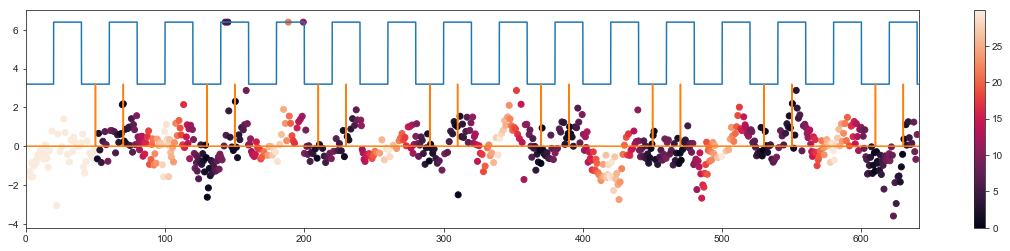

In [9]:
plt.figure(figsize=(20, 4))
n_comp = 0
len_t = len(frame_stimParams[2])
scale_ = burst_pca[:, n_comp].max()/frame_stimParams[2].max()
plt.plot(np.arange(len_t)/300, frame_stimParams[2]*scale_)
if 'Optovin' in task_type:
    swim_pain_t[np.isinf(swim_pain_t)]=swim_pain_t[~np.isinf(swim_pain_t)].max()
    plt.plot(np.arange(len_t)/300, frame_stimParams[5]*scale_)
    plt.scatter(swim_starts/300, burst_pca[:, n_comp], c=swim_pain_t/300)
    plt.colorbar()
else:
    plt.scatter(swim_starts/300, burst_pca[:, n_comp], c=swim_bout_index_task/300)
plt.xlim([0, len_t/300])
plt.show()

In [10]:
if burst_pca.shape[1]>1:
    plt.figure(figsize=(20, 4))
    n_comp = 1
    len_t = len(frame_stimParams[2])
    scale_ = burst_pca[:, 1].max()/frame_stimParams[2].max()
    plt.plot(np.arange(len_t)/300, frame_stimParams[2]*scale_)
    if 'Optovin' in task_type:
        swim_pain_t[np.isinf(swim_pain_t)]=swim_pain_t[~np.isinf(swim_pain_t)].max()
        plt.plot(np.arange(len_t)/300, frame_stimParams[5]*scale_)
        plt.scatter(swim_starts/300, burst_pca[:, n_comp], c=swim_pain_t/300)
        plt.colorbar()
    else:
        plt.scatter(swim_starts/300, burst_pca[:, n_comp], c=swim_bout_index_task)
    plt.xlim([0, len_t/300])
    plt.show()